## Hyperparameter optimization using hyperopt

In [8]:
from __future__ import print_function, division, absolute_import
# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# set_session(tf.Session(config=config))
# from clr_callback import CyclicLR
# import dill
from AudioDataGenerator import AudioDataGenerator
import os
import numpy as np
np.random.seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import tables
from datetime import datetime
import argparse
from keras.layers import Input, Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Activation, AveragePooling1D
from keras import initializers
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.optimizers import Adam  # Nadam, Adamax
from keras.callbacks import TensorBoard, Callback, ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, CSVLogger
from keras import backend as K
from keras.utils import plot_model
from custom_layers import Conv1D_zerophase_linear, Conv1D_linearphase, Conv1D_zerophase,\
    DCT1D, Conv1D_gammatone, Conv1D_linearphaseType
from heartnet_v1 import log_macc, write_meta, compute_weight, reshape_folds, results_log
from utils import DenseNet
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from keras.losses import categorical_crossentropy
sns.set()
import ast # for list import

In [9]:
def branch(input_tensor,num_filt,kernel_size,random_seed,padding,bias,maxnorm,l2_reg,
           eps,bn_momentum,activation_function,dropout_rate,subsam,trainable):

    num_filt1, num_filt2 = num_filt
    t = Conv1D(num_filt1, kernel_size=kernel_size,
                kernel_initializer=initializers.he_normal(seed=random_seed),
                padding=padding,
                use_bias=bias,
                kernel_constraint=max_norm(maxnorm),
                trainable=trainable,
                kernel_regularizer=l2(l2_reg))(input_tensor)
    t = BatchNormalization(epsilon=eps, momentum=bn_momentum, axis=-1)(t)
    t = Activation(activation_function)(t)
    t = Dropout(rate=dropout_rate, seed=random_seed)(t)
    t = MaxPooling1D(pool_size=subsam)(t)
    t = Conv1D(num_filt2, kernel_size=kernel_size,
               kernel_initializer=initializers.he_normal(seed=random_seed),
               padding=padding,
               use_bias=bias,
               trainable=trainable,
               kernel_constraint=max_norm(maxnorm),
               kernel_regularizer=l2(l2_reg))(t)
    t = BatchNormalization(epsilon=eps, momentum=bn_momentum, axis=-1)(t)
    t = Activation(activation_function)(t)
    t = Dropout(rate=dropout_rate, seed=random_seed)(t)
    t = MaxPooling1D(pool_size=subsam)(t)
    # t = Flatten()(t)
    return t

In [10]:
foldname='fold0_noFIR'


In [11]:
random_seed=1
batch_size=64
fold_dir = '/media/taufiq/Data1/heart_sound/feature/segmented_noFIR/folds_dec_2018/'
log_dir= '/media/taufiq/Data/heart_sound/Heart_Sound/codes/logs/'
bn_momentum = 0.99
eps= 1.1e-5
bias=False
l2_reg=0.
# l2_reg_dense=0.
kernel_size=5
maxnorm=10000.
dropout_rate=0.5
dropout_rate_dense=0.
padding='valid'
activation_function='relu'
subsam=2
load_path=False
lr=0.0012843784 
lr_decay=0.0001132885
FIR_train=True
num_filt=(8,4)
num_dense=20
params = dict()
print("values initialized")

model_dir = '/media/taufiq/Data1/heart_sound/models/'
fold_dir = '/media/taufiq/Data1/heart_sound/feature/segmented_noFIR/folds_dec_2018/'
log_name = foldname + ' ' + str(datetime.now())
log_dir = '/media/taufiq/Data1/heart_sound/logs/'
if not os.path.exists(model_dir + log_name):
    os.makedirs(model_dir + log_name)
checkpoint_name = model_dir + log_name + "/" + 'weights.{epoch:04d}-{val_acc:.4f}.hdf5'
results_path = '/media/taufiq/Data1/heart_sound/results_2class.csv'

num_filt = (8, 4)
num_dense = 20

bn_momentum = 0.99
eps = 1.1e-5
bias = False
l2_reg = 0.04864911065093751
l2_reg_dense = 0.
kernel_size = 5
maxnorm = 10000.
dropout_rate = 0.5
dropout_rate_dense = 0.
padding = 'valid'
activation_function = 'relu'
subsam = 2
FIR_train= True
trainable = True
decision = 'majority'  # Decision algorithm for inference over total recording ('majority','confidence')

# lr =  0.00125 ## After bayesian optimization

###### lr_decay optimization ######
lr_decay =0.0001132885

values initialized


In [12]:
feat = tables.open_file(fold_dir + foldname + '.mat')
x_train = feat.root.trainX[:]
y_train = feat.root.trainY[0, :]
x_val = feat.root.valX[:]
y_val = feat.root.valY[0, :]
train_parts = feat.root.train_parts[:]
val_parts = feat.root.val_parts[0, :]

############## Relabeling ################

for i in range(0, y_train.shape[0]):
    if y_train[i] == -1:
        y_train[i] = 0  ## Label 0 for normal 1 for abnormal
for i in range(0, y_val.shape[0]):
    if y_val[i] == -1:
        y_val[i] = 0

############# Parse Database names ########

train_files = []
for each in feat.root.train_files[:][0]:
    train_files.append(chr(each))
print(len(train_files))
val_files = []
for each in feat.root.val_files[:][0]:
    val_files.append(chr(each))
print(len(val_files))

################### Reshaping ############

x_train, y_train, x_val, y_val = reshape_folds(x_train, x_val, y_train, y_val)
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

79810
6710
(79810, 2500, 1)
(79810, 1)
(6710, 2500, 1)
(6710, 1)


In [13]:
datagen = AudioDataGenerator(shift=.1,
                             # roll_range=.1,
                             # fill_mode='reflect',
                             # featurewise_center=True,
                             # zoom_range=.1,
                             # zca_whitening=True,
                             # samplewise_center=True,
                             # samplewise_std_normalization=True,
                             )

In [17]:
def heartnet(load_path,activation_function='relu', bn_momentum=0.99,
             bias=False, dropout_rate=0.5, dropout_rate_dense=0.0,
             eps=1.1e-5, kernel_size=5, l2_reg=0.0, l2_reg_dense=0.0,
             lr=0.0012843784, lr_decay=0.0001132885, maxnorm=10000.,
             padding='valid', random_seed=1, subsam=2, num_filt=(8, 4),
             num_dense=20,FIR_train=False,trainable=True,type_=1,args=1):

    input = Input(shape=(2500, 1))

    coeff_path = '/media/taufiq/Data1/heart_sound/heartnetTransfer/filterbankcoeff60.mat'
    coeff = tables.open_file(coeff_path)
    b1 = coeff.root.b1[:]
    b1 = np.hstack(b1)
    b1 = np.reshape(b1, [b1.shape[0], 1, 1])

    b2 = coeff.root.b2[:]
    b2 = np.hstack(b2)
    b2 = np.reshape(b2, [b2.shape[0], 1, 1])

    b3 = coeff.root.b3[:]
    b3 = np.hstack(b3)
    b3 = np.reshape(b3, [b3.shape[0], 1, 1])

    b4 = coeff.root.b4[:]
    b4 = np.hstack(b4)
    b4 = np.reshape(b4, [b4.shape[0], 1, 1])

    ## Conv1D_linearphase

    # input1 = Conv1D_linearphase(1 ,61, use_bias=False,
    #                 # kernel_initializer=initializers.he_normal(random_seed),
    #                 weights=[b1[30:]],
    #                 padding='same',trainable=FIR_train)(input)
    # input2 = Conv1D_linearphase(1, 61, use_bias=False,
    #                 # kernel_initializer=initializers.he_normal(random_seed),
    #                 weights=[b2[30:]],
    #                 padding='same',trainable=FIR_train)(input)
    # input3 = Conv1D_linearphase(1, 61, use_bias=False,
    #                 # kernel_initializer=initializers.he_normal(random_seed),
    #                 weights=[b3[30:]],
    #                 padding='same',trainable=FIR_train)(input)
    # input4 = Conv1D_linearphase(1, 61, use_bias=False,
    #                 # kernel_initializer=initializers.he_normal(random_seed),
    #                 weights=[b4[30:]],
    #                 padding='same',trainable=FIR_train)(input)

    ## Conv1D_linearphase Anti-Symmetric
    #

    if type_ % 2:
        weight_idx = 30
    else:
        weight_idx = 31

    input1 = Conv1D_linearphaseType(1 ,61, use_bias=False,
                    # kernel_initializer=initializers.he_normal(random_seed),
                    weights=[b1[weight_idx:]],
                    padding='same',trainable=FIR_train, type = type_)(input)
    input2 = Conv1D_linearphaseType(1, 61, use_bias=False,
                    # kernel_initializer=initializers.he_normal(random_seed),
                    weights=[b2[weight_idx:]],
                    padding='same',trainable=FIR_train, type = type_)(input)
    input3 = Conv1D_linearphaseType(1, 61, use_bias=False,
                    # kernel_initializer=initializers.he_normal(random_seed),
                    weights=[b3[weight_idx:]],
                    padding='same',trainable=FIR_train, type = type_)(input)
    input4 = Conv1D_linearphaseType(1, 61, use_bias=False,
                    # kernel_initializer=initializers.he_normal(random_seed),
                    weights=[b4[weight_idx:]],
                    padding='same',trainable=FIR_train, type = type_)(input)

    #Conv1D_gammatone

    # input1 = Conv1D_gammatone(kernel_size=81,filters=1,fsHz=1000,use_bias=False,padding='same')(input)
    # input2 = Conv1D_gammatone(kernel_size=81,filters=1,fsHz=1000,use_bias=False,padding='same')(input)
    # input3 = Conv1D_gammatone(kernel_size=81,filters=1,fsHz=1000,use_bias=False,padding='same')(input)
    # input4 = Conv1D_gammatone(kernel_size=81,filters=1,fsHz=1000,use_bias=False,padding='same')(input)

    t1 = branch(input1,num_filt,kernel_size,random_seed,padding,bias,maxnorm,l2_reg,
           eps,bn_momentum,activation_function,dropout_rate,subsam,trainable)
    t2 = branch(input2,num_filt,kernel_size,random_seed,padding,bias,maxnorm,l2_reg,
           eps,bn_momentum,activation_function,dropout_rate,subsam,trainable)
    t3 = branch(input3,num_filt,kernel_size,random_seed,padding,bias,maxnorm,l2_reg,
           eps,bn_momentum,activation_function,dropout_rate,subsam,trainable)
    t4 = branch(input4,num_filt,kernel_size,random_seed,padding,bias,maxnorm,l2_reg,
           eps,bn_momentum,activation_function,dropout_rate,subsam,trainable)

    merged = Concatenate(axis=-1)([t1, t2, t3, t4])
    merged = DenseNet(merged,
                      depth=int(3*args[0]+4),
                      nb_dense_block=args[1],
                      growth_rate=int(args[2]),
#                       kernel_size=args[3],
                      kernel_size=5,
#                       nb_filter=args[4],
                      nb_filter=16,
#                       dropout_rate=args[5],
                      dropout_rate=dropout_rate,
                     )
    # 7,4,4,5,16; 7,1,4,5,16

    # merged = DCT1D()(merged)
    merged = Flatten()(merged)
    merged = Dense(num_dense,
                   activation=activation_function,
                   kernel_initializer=initializers.he_normal(seed=random_seed),
                   use_bias=bias,
                   kernel_constraint=max_norm(maxnorm),
                   kernel_regularizer=l2(l2_reg_dense))(merged)
    # merged = BatchNormalization(epsilon=eps,momentum=bn_momentum,axis=-1) (merged)
    # merged = Activation(activation_function)(merged)
    merged = Dropout(rate=dropout_rate_dense, seed=random_seed)(merged)
    merged = Dense(2, activation='softmax')(merged)

    model = Model(inputs=input, outputs=merged)

    if load_path:  # If path for loading model was specified
        model.load_weights(filepath=load_path, by_name=False)

    adam = Adam(lr=lr, decay=lr_decay)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [19]:
def objective(args):
    print("args {}".format(args))
    
    log_name = "hyperopt-{}".format(args) + str(datetime.now())
    if not os.path.exists(model_dir + log_name):
        os.makedirs(model_dir + log_name)
    checkpoint_name = model_dir + log_name + "/" + 'weights.{epoch:04d}-{val_acc:.4f}.hdf5'
    
    
    csv_logger = CSVLogger(log_dir + log_name + '/training.csv')
    tensbd = TensorBoard(log_dir=log_dir + log_name,
                            batch_size=batch_size)
    modelcheckpnt = ModelCheckpoint(filepath=checkpoint_name,
                                monitor='val_acc',
                                save_best_only=True, mode='max')
    
    model = heartnet(load_path,activation_function, bn_momentum, bias, dropout_rate, dropout_rate_dense,
                         eps, kernel_size, l2_reg, l2_reg_dense, lr, lr_decay, maxnorm,
                         padding, random_seed, subsam, num_filt, num_dense, FIR_train, trainable, 1, args)
    model.summary()
    model.fit_generator(datagen.flow(x_train, y_train, batch_size, shuffle=True,
                                     seed=random_seed),
                            steps_per_epoch=len(x_train) // batch_size,
                            # max_queue_size=20,
                            use_multiprocessing=False,
                            epochs=20,
                            verbose=1,
                            shuffle=True,
                            callbacks=[modelcheckpnt,
                                       log_macc(val_parts, decision=decision,verbose=1, val_files=val_files),
                                       tensbd, csv_logger],
                            validation_data=(x_val, y_val),
                            initial_epoch=0,
                            )
    y_pred = model.predict(x_val)
    loss = K.eval(K.mean(K.variable(K.eval(categorical_crossentropy(K.variable(y_val),K.variable(y_pred))))))
    params[str(args)]=loss
    print("Loss: %d" % loss)
    return loss    

In [20]:
from hyperopt import hp, Trials, fmin, tpe
trials = Trials()
best = fmin(objective,
    space=[hp.quniform('depth',1,30,1),
           hp.choice('num_block',[1,2,3]),
           hp.quniform('growth',1,20,1),
#            hp.choice('kernel_size',[3,5,7]),
#            hp.choice('num_filters',[8,16,32]),
#            hp.normal('dropout',0.4,0.1)
          ],
    algo=tpe.suggest,
    max_evals=20,
    trials=trials)

args (23.0, 1, 4.0)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 2500, 1)      0                                            
__________________________________________________________________________________________________
conv1d_linearphase_type_5 (Conv (None, 2500, 1)      31          input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_linearphase_type_6 (Conv (None, 2500, 1)      31          input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_linearphase_type_7 (Conv (None, 2500, 1)      31          input_2[0][0]                    
_________________________________________________________________________________________

Epoch 1/20
6710/6710 [==============================] - 5s 721us/step
TN:96,FP:50,FN:50,TP:88,Macc:0.647607652813,F1:0.637675608638
Epoch 2/20
6710/6710 [==============================] - 3s 513us/step
TN:72,FP:74,FN:27,TP:111,Macc:0.648749204874,F1:0.68730107123
Epoch 3/20
6710/6710 [==============================] - 3s 510us/step
TN:57,FP:89,FN:14,TP:124,Macc:0.644480791252,F1:0.70654741342
Epoch 4/20
6710/6710 [==============================] - 4s 523us/step
TN:47,FP:99,FN:4,TP:134,Macc:0.64646609966,F1:0.722366785486
Epoch 5/20
6710/6710 [==============================] - 3s 510us/step
TN:39,FP:107,FN:0,TP:138,Macc:0.633561593918,F1:0.720621519768
Epoch 6/20
6710/6710 [==============================] - 3s 513us/step
TN:67,FP:79,FN:24,TP:114,Macc:0.642495482844,F1:0.688816358381
Epoch 7/20
6710/6710 [==============================] - 4s 525us/step
TN:45,FP:101,FN:4,TP:134,Macc:0.639616785107,F1:0.718493489129
Epoch 8/20
6710/6710 [==============================] - 4s 526us/step
TN:3

Epoch 1/20
6710/6710 [==============================] - 7s 1ms/step
TN:37,FP:109,FN:7,TP:131,Macc:0.601349962546,F1:0.693116553297
Epoch 2/20
6710/6710 [==============================] - 5s 718us/step
TN:49,FP:97,FN:12,TP:126,Macc:0.624329909276,F1:0.698055704246
Epoch 3/20
6710/6710 [==============================] - 5s 715us/step
TN:27,FP:119,FN:2,TP:136,Macc:0.585219330369,F1:0.692106908051
Epoch 4/20
6710/6710 [==============================] - 5s 740us/step
TN:23,FP:123,FN:0,TP:138,Macc:0.578767077498,F1:0.691724307873
Epoch 5/20
6710/6710 [==============================] - 5s 729us/step
TN:28,FP:118,FN:2,TP:136,Macc:0.588643987645,F1:0.693872493737
Epoch 6/20
6710/6710 [==============================] - 5s 709us/step
TN:45,FP:101,FN:5,TP:133,Macc:0.63599359699,F1:0.715048587475
Epoch 7/20
6710/6710 [==============================] - 5s 724us/step
TN:36,FP:110,FN:2,TP:136,Macc:0.616041245855,F1:0.708328227846
Epoch 8/20
6710/6710 [==============================] - 5s 739us/step
TN

Epoch 1/20
6710/6710 [==============================] - 10s 1ms/step
TN:146,FP:0,FN:138,TP:0,Macc:0.499999962329,F1:0.0
Epoch 2/20
6710/6710 [==============================] - 7s 1ms/step
TN:146,FP:0,FN:138,TP:0,Macc:0.499999962329,F1:0.0
Epoch 3/20
6710/6710 [==============================] - 7s 1ms/step
TN:68,FP:78,FN:26,TP:112,Macc:0.638673763886,F1:0.68292142174
Epoch 4/20
6710/6710 [==============================] - 7s 1ms/step
TN:77,FP:69,FN:26,TP:112,Macc:0.669495679372,F1:0.702188908916
Epoch 5/20
6710/6710 [==============================] - 7s 1ms/step
TN:73,FP:73,FN:32,TP:106,Macc:0.634057921566,F1:0.668764261724
Epoch 6/20
6710/6710 [==============================] - 7s 1ms/step
TN:32,FP:114,FN:12,TP:126,Macc:0.56611073558,F1:0.666661528384
Epoch 7/20
6710/6710 [==============================] - 7s 1ms/step
TN:43,FP:103,FN:10,TP:128,Macc:0.611028341853,F1:0.693761745707
Epoch 8/20
6710/6710 [==============================] - 7s 1ms/step
TN:82,FP:64,FN:36,TP:102,Macc:0.650387

Epoch 1/20
6710/6710 [==============================] - 15s 2ms/step
TN:30,FP:116,FN:4,TP:134,Macc:0.588246925964,F1:0.690716568641
Epoch 2/20
6710/6710 [==============================] - 10s 1ms/step
TN:60,FP:86,FN:16,TP:122,Macc:0.647508386847,F1:0.705196992455
Epoch 3/20
6710/6710 [==============================] - 10s 1ms/step
TN:37,FP:109,FN:6,TP:132,Macc:0.604973150663,F1:0.696564786665
Epoch 4/20
6710/6710 [==============================] - 10s 1ms/step
TN:36,FP:110,FN:1,TP:137,Macc:0.619664433972,F1:0.71168321191
Epoch 5/20
6710/6710 [==============================] - 10s 1ms/step
TN:119,FP:27,FN:68,TP:70,Macc:0.66115738406,F1:0.595739292542
Epoch 6/20
6710/6710 [==============================] - 10s 1ms/step
TN:142,FP:4,FN:118,TP:20,Macc:0.558765095564,F1:0.24691077034
Epoch 7/20
6710/6710 [==============================] - 10s 1ms/step
TN:139,FP:7,FN:113,TP:25,Macc:0.56660706432,F1:0.294114247374
Epoch 8/20
6710/6710 [==============================] - 10s 1ms/step
TN:112,FP:3

Epoch 1/20
6710/6710 [==============================] - 7s 1ms/step
TN:66,FP:80,FN:19,TP:119,Macc:0.657186766153,F1:0.706226088145
Epoch 2/20
6710/6710 [==============================] - 3s 444us/step
TN:52,FP:94,FN:10,TP:128,Macc:0.641850257339,F1:0.711105867137
Epoch 3/20
6710/6710 [==============================] - 3s 435us/step
TN:28,FP:118,FN:2,TP:136,Macc:0.588643987645,F1:0.693872493737
Epoch 4/20
6710/6710 [==============================] - 3s 427us/step
TN:54,FP:92,FN:25,TP:113,Macc:0.594351750136,F1:0.658886795918
Epoch 5/20
6710/6710 [==============================] - 3s 426us/step
TN:30,FP:116,FN:3,TP:135,Macc:0.591870114081,F1:0.694082328491
Epoch 6/20
6710/6710 [==============================] - 3s 438us/step
TN:71,FP:75,FN:34,TP:104,Macc:0.619962230779,F1:0.656145966071
Epoch 7/20
6710/6710 [==============================] - 3s 415us/step
TN:121,FP:25,FN:71,TP:67,Macc:0.657137134262,F1:0.582603359972
Epoch 8/20
6710/6710 [==============================] - 3s 449us/step
T

Epoch 1/20
6710/6710 [==============================] - 7s 1ms/step
TN:140,FP:6,FN:126,TP:12,Macc:0.522930276075,F1:0.15384388662
Epoch 2/20
6710/6710 [==============================] - 3s 397us/step
TN:57,FP:89,FN:20,TP:118,Macc:0.62274166255,F1:0.684052647434
Epoch 3/20
6710/6710 [==============================] - 3s 413us/step
TN:57,FP:89,FN:10,TP:128,Macc:0.65897354372,F1:0.721121488282
Epoch 4/20
6710/6710 [==============================] - 3s 399us/step
TN:66,FP:80,FN:13,TP:125,Macc:0.678925894855,F1:0.728857636907
Epoch 5/20
6710/6710 [==============================] - 3s 397us/step
TN:89,FP:57,FN:42,TP:96,Macc:0.652620556815,F1:0.659788279211
Epoch 6/20
6710/6710 [==============================] - 3s 388us/step
TN:72,FP:74,FN:28,TP:110,Macc:0.645126016757,F1:0.683224379272
Epoch 7/20
6710/6710 [==============================] - 3s 418us/step
TN:76,FP:70,FN:29,TP:109,Macc:0.655201457745,F1:0.687691705204
Epoch 8/20
6710/6710 [==============================] - 3s 396us/step
TN:76

Epoch 1/20
6710/6710 [==============================] - 6s 930us/step
TN:110,FP:36,FN:74,TP:64,Macc:0.608596339872,F1:0.537809716599
Epoch 2/20
6710/6710 [==============================] - 2s 277us/step
TN:85,FP:61,FN:38,TP:100,Macc:0.653414680178,F1:0.668890804443
Epoch 3/20
6710/6710 [==============================] - 2s 309us/step
TN:81,FP:65,FN:39,TP:99,Macc:0.636092862956,F1:0.655623632123
Epoch 4/20
6710/6710 [==============================] - 2s 304us/step
TN:90,FP:56,FN:46,TP:92,Macc:0.641552461623,F1:0.643351100639
Epoch 5/20
6710/6710 [==============================] - 2s 311us/step
TN:80,FP:66,FN:34,TP:104,Macc:0.650784146265,F1:0.6753191865
Epoch 6/20
6710/6710 [==============================] - 2s 272us/step
TN:78,FP:68,FN:27,TP:111,Macc:0.669297148532,F1:0.700310000858
Epoch 7/20
6710/6710 [==============================] - 2s 286us/step
TN:71,FP:75,FN:27,TP:111,Macc:0.645324547598,F1:0.685179759416
Epoch 8/20
6710/6710 [==============================] - 2s 283us/step
TN:

Epoch 1/20
6710/6710 [==============================] - 10s 2ms/step
TN:71,FP:75,FN:16,TP:122,Macc:0.685179616885,F1:0.728352831761
Epoch 2/20
6710/6710 [==============================] - 5s 796us/step
TN:72,FP:74,FN:34,TP:104,Macc:0.623386888055,F1:0.658222390447
Epoch 3/20
6710/6710 [==============================] - 5s 765us/step
TN:94,FP:52,FN:39,TP:99,Macc:0.680613407547,F1:0.685115566285
Epoch 4/20
6710/6710 [==============================] - 5s 767us/step
TN:92,FP:54,FN:45,TP:93,Macc:0.652024964293,F1:0.6526260341
Epoch 5/20
6710/6710 [==============================] - 5s 759us/step
TN:61,FP:85,FN:17,TP:121,Macc:0.647309856006,F1:0.703483042056
Epoch 6/20
6710/6710 [==============================] - 5s 776us/step
TN:76,FP:70,FN:29,TP:109,Macc:0.655201457745,F1:0.687691705204
Epoch 7/20
6710/6710 [==============================] - 5s 750us/step
TN:95,FP:51,FN:49,TP:89,Macc:0.647806183654,F1:0.640282219446
Epoch 8/20
6710/6710 [==============================] - 5s 750us/step
TN:93

Epoch 1/20
6710/6710 [==============================] - 21s 3ms/step
TN:146,FP:0,FN:138,TP:0,Macc:0.499999962329,F1:0.0
Epoch 2/20
6710/6710 [==============================] - 14s 2ms/step
TN:37,FP:109,FN:28,TP:110,Macc:0.525263012089,F1:0.616241243804
Epoch 3/20
6710/6710 [==============================] - 14s 2ms/step
TN:59,FP:87,FN:8,TP:130,Macc:0.673069234506,F1:0.732389093217
Epoch 4/20
6710/6710 [==============================] - 14s 2ms/step
TN:45,FP:101,FN:5,TP:133,Macc:0.63599359699,F1:0.715048587475
Epoch 5/20
6710/6710 [==============================] - 14s 2ms/step
TN:38,FP:108,FN:3,TP:135,Macc:0.61926737229,F1:0.708656294165
Epoch 6/20
6710/6710 [==============================] - 14s 2ms/step
TN:43,FP:103,FN:5,TP:133,Macc:0.629144282438,F1:0.711224782358
Epoch 7/20
6710/6710 [==============================] - 14s 2ms/step
TN:63,FP:83,FN:7,TP:131,Macc:0.690391051728,F1:0.744312891727
Epoch 8/20
6710/6710 [==============================] - 14s 2ms/step
TN:72,FP:74,FN:25,TP:1

Epoch 1/20
6710/6710 [==============================] - 15s 2ms/step
TN:146,FP:0,FN:138,TP:0,Macc:0.499999962329,F1:0.0
Epoch 2/20
6710/6710 [==============================] - 7s 1ms/step
TN:146,FP:0,FN:138,TP:0,Macc:0.499999962329,F1:0.0
Epoch 3/20
6710/6710 [==============================] - 8s 1ms/step
TN:114,FP:32,FN:71,TP:67,Macc:0.633164533328,F1:0.565395440382
Epoch 4/20
6710/6710 [==============================] - 8s 1ms/step
TN:96,FP:50,FN:55,TP:83,Macc:0.629491712228,F1:0.612540577656
Epoch 5/20
6710/6710 [==============================] - 8s 1ms/step
TN:105,FP:41,FN:55,TP:83,Macc:0.660313627714,F1:0.633582248809
Epoch 6/20
6710/6710 [==============================] - 8s 1ms/step
TN:81,FP:65,FN:35,TP:103,Macc:0.650585615424,F1:0.673197118887
Epoch 7/20
6710/6710 [==============================] - 8s 1ms/step
TN:107,FP:39,FN:57,TP:81,Macc:0.659916566032,F1:0.627901450021
Epoch 8/20
6710/6710 [==============================] - 8s 1ms/step
TN:104,FP:42,FN:58,TP:80,Macc:0.6460194

Epoch 1/20
6710/6710 [==============================] - 17s 2ms/step
TN:146,FP:0,FN:138,TP:0,Macc:0.499999962329,F1:0.0
Epoch 2/20
6710/6710 [==============================] - 9s 1ms/step
TN:140,FP:6,FN:126,TP:12,Macc:0.522930276075,F1:0.15384388662
Epoch 3/20
6710/6710 [==============================] - 9s 1ms/step
TN:44,FP:102,FN:3,TP:135,Macc:0.639815315948,F1:0.719994841124
Epoch 4/20
6710/6710 [==============================] - 9s 1ms/step
TN:28,FP:118,FN:37,TP:101,Macc:0.461832403551,F1:0.565821078848
Epoch 5/20
6710/6710 [==============================] - 9s 1ms/step
TN:24,FP:122,FN:23,TP:115,Macc:0.498858408083,F1:0.613328180722
Epoch 6/20
6710/6710 [==============================] - 9s 1ms/step
TN:61,FP:85,FN:19,TP:119,Macc:0.640063479772,F1:0.695901092855
Epoch 7/20
6710/6710 [==============================] - 9s 1ms/step
TN:72,FP:74,FN:31,TP:107,Macc:0.634256452406,F1:0.670840948698
Epoch 8/20
6710/6710 [==============================] - 9s 1ms/step
TN:146,FP:0,FN:138,TP:0,M

Epoch 1/20
6710/6710 [==============================] - 10s 2ms/step
TN:125,FP:21,FN:106,TP:32,Macc:0.544024179272,F1:0.335074084759
Epoch 2/20
6710/6710 [==============================] - 2s 343us/step
TN:101,FP:45,FN:68,TP:70,Macc:0.599513553088,F1:0.553354181185
Epoch 3/20
6710/6710 [==============================] - 2s 354us/step
TN:145,FP:1,FN:127,TP:11,Macc:0.536430374339,F1:0.146665025972
Epoch 4/20
6710/6710 [==============================] - 2s 356us/step
TN:146,FP:0,FN:131,TP:7,Macc:0.525362279148,F1:0.0965506987013
Epoch 5/20
6710/6710 [==============================] - 2s 347us/step
TN:146,FP:0,FN:128,TP:10,Macc:0.536231843499,F1:0.135133729012
Epoch 6/20
6710/6710 [==============================] - 2s 353us/step
TN:146,FP:0,FN:135,TP:3,Macc:0.51086952668,F1:0.0425527267274
Epoch 7/20
6710/6710 [==============================] - 2s 349us/step
TN:146,FP:0,FN:138,TP:0,Macc:0.499999962329,F1:0.0
Epoch 8/20
6710/6710 [==============================] - 2s 346us/step
TN:146,FP:0,

Epoch 1/20
6710/6710 [==============================] - 17s 3ms/step
TN:146,FP:0,FN:138,TP:0,Macc:0.499999962329,F1:0.0
Epoch 2/20
6710/6710 [==============================] - 9s 1ms/step
TN:119,FP:27,FN:59,TP:79,Macc:0.693766077113,F1:0.647535519865
Epoch 3/20
6710/6710 [==============================] - 9s 1ms/step
TN:83,FP:63,FN:40,TP:98,Macc:0.639318989392,F1:0.655512879007
Epoch 4/20
6710/6710 [==============================] - 9s 1ms/step
TN:94,FP:52,FN:57,TP:81,Macc:0.615396021441,F1:0.597780431254
Epoch 5/20
6710/6710 [==============================] - 9s 1ms/step
TN:29,FP:117,FN:0,TP:138,Macc:0.599315021155,F1:0.702285024529
Epoch 6/20
6710/6710 [==============================] - 9s 1ms/step
TN:21,FP:125,FN:0,TP:138,Macc:0.571917762946,F1:0.688274298454
Epoch 7/20
6710/6710 [==============================] - 9s 1ms/step
TN:65,FP:81,FN:29,TP:109,Macc:0.617530227707,F1:0.664628740042
Epoch 8/20
6710/6710 [==============================] - 9s 1ms/step
TN:48,FP:98,FN:8,TP:130,Macc

Epoch 1/20
6710/6710 [==============================] - 13s 2ms/step
TN:37,FP:109,FN:8,TP:130,Macc:0.597726774429,F1:0.689650026957
Epoch 2/20
6710/6710 [==============================] - 4s 544us/step
TN:77,FP:69,FN:27,TP:111,Macc:0.665872491255,F1:0.698107755233
Epoch 3/20
6710/6710 [==============================] - 4s 584us/step
TN:53,FP:93,FN:12,TP:126,Macc:0.638028538381,F1:0.705877092617
Epoch 4/20
6710/6710 [==============================] - 4s 556us/step
TN:42,FP:104,FN:4,TP:134,Macc:0.629342813278,F1:0.712760804813
Epoch 5/20
6710/6710 [==============================] - 4s 543us/step
TN:113,FP:33,FN:66,TP:72,Macc:0.647855816637,F1:0.592587140424
Epoch 6/20
6710/6710 [==============================] - 4s 543us/step
TN:42,FP:104,FN:6,TP:132,Macc:0.622096437044,F1:0.70587718909
Epoch 7/20
6710/6710 [==============================] - 4s 549us/step
TN:110,FP:36,FN:67,TP:71,Macc:0.633958656691,F1:0.579586372795
Epoch 8/20
6710/6710 [==============================] - 4s 535us/step
T

Epoch 1/20
6710/6710 [==============================] - 17s 3ms/step
TN:146,FP:0,FN:138,TP:0,Macc:0.499999962329,F1:0.0
Epoch 2/20
6710/6710 [==============================] - 5s 787us/step
TN:46,FP:100,FN:6,TP:132,Macc:0.635795066149,F1:0.713508326114
Epoch 3/20
6710/6710 [==============================] - 5s 812us/step
TN:62,FP:84,FN:12,TP:126,Macc:0.668850453867,F1:0.724132620728
Epoch 4/20
6710/6710 [==============================] - 5s 793us/step
TN:90,FP:56,FN:31,TP:107,Macc:0.695900283378,F1:0.710957941168
Epoch 5/20
6710/6710 [==============================] - 5s 795us/step
TN:75,FP:71,FN:18,TP:120,Macc:0.691631869756,F1:0.729477876666
Epoch 6/20
6710/6710 [==============================] - 5s 800us/step
TN:59,FP:87,FN:6,TP:132,Macc:0.68031561074,F1:0.739490535922
Epoch 7/20
6710/6710 [==============================] - 5s 810us/step
TN:58,FP:88,FN:10,TP:128,Macc:0.662398200996,F1:0.723158563924
Epoch 8/20
6710/6710 [==============================] - 5s 793us/step
TN:77,FP:69,FN

Epoch 1/20
6710/6710 [==============================] - 19s 3ms/step
TN:146,FP:0,FN:138,TP:0,Macc:0.499999962329,F1:0.0
Epoch 2/20
6710/6710 [==============================] - 8s 1ms/step
TN:23,FP:123,FN:0,TP:138,Macc:0.578767077498,F1:0.691724307873
Epoch 3/20
6710/6710 [==============================] - 8s 1ms/step
TN:47,FP:99,FN:11,TP:127,Macc:0.621103782841,F1:0.697796977124
Epoch 4/20
6710/6710 [==============================] - 8s 1ms/step
TN:66,FP:80,FN:28,TP:110,Macc:0.6245780731,F1:0.670726300608
Epoch 5/20
6710/6710 [==============================] - 8s 1ms/step
TN:36,FP:110,FN:8,TP:130,Macc:0.594302117153,F1:0.687825548315
Epoch 6/20
6710/6710 [==============================] - 8s 1ms/step
TN:49,FP:97,FN:13,TP:125,Macc:0.620706721159,F1:0.69443920149
Epoch 7/20
6710/6710 [==============================] - 8s 1ms/step
TN:87,FP:59,FN:44,TP:94,Macc:0.638524866029,F1:0.646042575784
Epoch 8/20
6710/6710 [==============================] - 8s 1ms/step
TN:68,FP:78,FN:32,TP:106,Macc:

Epoch 1/20
6710/6710 [==============================] - 14s 2ms/step
TN:24,FP:122,FN:5,TP:133,Macc:0.564075794189,F1:0.676839733334
Epoch 2/20
6710/6710 [==============================] - 2s 372us/step
TN:66,FP:80,FN:15,TP:123,Macc:0.671679518621,F1:0.721402277969
Epoch 3/20
6710/6710 [==============================] - 3s 373us/step
TN:47,FP:99,FN:8,TP:130,Macc:0.631973347192,F1:0.708441662207
Epoch 4/20
6710/6710 [==============================] - 3s 400us/step
TN:98,FP:48,FN:53,TP:85,Macc:0.643587403014,F1:0.627300724058
Epoch 5/20
6710/6710 [==============================] - 3s 379us/step
TN:77,FP:69,FN:31,TP:107,Macc:0.651379738787,F1:0.681523195264
Epoch 6/20
6710/6710 [==============================] - 3s 377us/step
TN:67,FP:79,FN:14,TP:124,Macc:0.678727364014,F1:0.72726738023
Epoch 7/20
6710/6710 [==============================] - 3s 379us/step
TN:76,FP:70,FN:20,TP:118,Macc:0.687810150798,F1:0.723920960934
Epoch 8/20
6710/6710 [==============================] - 3s 379us/step
TN:

Epoch 1/20
6710/6710 [==============================] - 19s 3ms/step
TN:146,FP:0,FN:138,TP:0,Macc:0.499999962329,F1:0.0
Epoch 2/20
6710/6710 [==============================] - 7s 1ms/step
TN:146,FP:0,FN:138,TP:0,Macc:0.499999962329,F1:0.0
Epoch 3/20
6710/6710 [==============================] - 7s 1ms/step
TN:9,FP:137,FN:0,TP:138,Macc:0.530821875631,F1:0.668275941315
Epoch 4/20
6710/6710 [==============================] - 7s 1ms/step
TN:7,FP:139,FN:0,TP:138,Macc:0.523972561079,F1:0.665055322759
Epoch 5/20
6710/6710 [==============================] - 7s 1ms/step
TN:36,FP:110,FN:2,TP:136,Macc:0.616041245855,F1:0.708328227846
Epoch 6/20
6710/6710 [==============================] - 7s 1ms/step
TN:28,FP:118,FN:3,TP:135,Macc:0.585020799528,F1:0.69053202136
Epoch 7/20
6710/6710 [==============================] - 7s 1ms/step
TN:4,FP:142,FN:0,TP:138,Macc:0.51369858925,F1:0.66028218135
Epoch 8/20
6710/6710 [==============================] - 7s 1ms/step
TN:10,FP:136,FN:0,TP:138,Macc:0.534246532907

Epoch 1/20
6710/6710 [==============================] - 26s 4ms/step
TN:55,FP:91,FN:13,TP:125,Macc:0.641254664816,F1:0.706209412436
Epoch 2/20
6710/6710 [==============================] - 9s 1ms/step
TN:94,FP:52,FN:31,TP:107,Macc:0.709598912483,F1:0.720533194704
Epoch 3/20
6710/6710 [==============================] - 9s 1ms/step
TN:146,FP:0,FN:130,TP:8,Macc:0.528985467265,F1:0.109587885167
Epoch 4/20
6710/6710 [==============================] - 9s 1ms/step
TN:146,FP:0,FN:130,TP:8,Macc:0.528985467265,F1:0.109587885167
Epoch 5/20
6710/6710 [==============================] - 9s 1ms/step
TN:146,FP:0,FN:133,TP:5,Macc:0.518115902914,F1:0.0699293168434
Epoch 6/20
6710/6710 [==============================] - 9s 1ms/step
TN:146,FP:0,FN:135,TP:3,Macc:0.51086952668,F1:0.0425527267274
Epoch 7/20
6710/6710 [==============================] - 9s 1ms/step
TN:146,FP:0,FN:133,TP:5,Macc:0.518115902914,F1:0.0699293168434
Epoch 8/20
6710/6710 [==============================] - 9s 1ms/step
TN:146,FP:0,FN:13

Epoch 1/20
6710/6710 [==============================] - 19s 3ms/step
TN:40,FP:106,FN:7,TP:131,Macc:0.611623934375,F1:0.698661509044
Epoch 2/20
6710/6710 [==============================] - 4s 612us/step
TN:60,FP:86,FN:20,TP:118,Macc:0.633015634379,F1:0.690053140015
Epoch 3/20
6710/6710 [==============================] - 4s 602us/step
TN:52,FP:94,FN:10,TP:128,Macc:0.641850257339,F1:0.711105867137
Epoch 4/20
6710/6710 [==============================] - 4s 609us/step
TN:41,FP:105,FN:6,TP:132,Macc:0.618671779768,F1:0.703994842064
Epoch 5/20
6710/6710 [==============================] - 4s 596us/step
TN:57,FP:89,FN:14,TP:124,Macc:0.644480791252,F1:0.70654741342
Epoch 6/20
6710/6710 [==============================] - 4s 618us/step
TN:86,FP:60,FN:38,TP:100,Macc:0.656839337455,F1:0.671135420071
Epoch 7/20
6710/6710 [==============================] - 4s 612us/step
TN:146,FP:0,FN:135,TP:3,Macc:0.51086952668,F1:0.0425527267274
Epoch 8/20
6710/6710 [==============================] - 4s 642us/step
TN

In [22]:
best

{'depth': 14.0, 'growth': 1.0, 'num_block': 1}

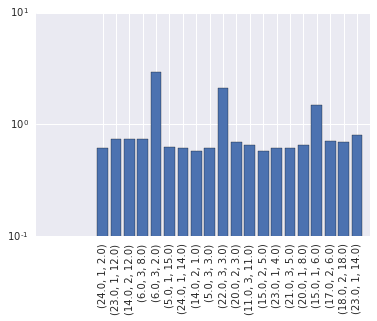

In [21]:
import matplotlib.pyplot as plt

D =(params)

plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()),rotation=90)
plt.yscale('log',nonposy='clip')
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x

plt.show()

In [23]:
D

{'(11.0, 3, 11.0)': 0.646338,
 '(14.0, 2, 1.0)': 0.57632357,
 '(14.0, 2, 12.0)': 0.74172616,
 '(15.0, 1, 6.0)': 1.4967262,
 '(15.0, 2, 5.0)': 0.5805792,
 '(17.0, 2, 6.0)': 0.7044638,
 '(18.0, 2, 18.0)': 0.6994753,
 '(20.0, 1, 8.0)': 0.64769423,
 '(20.0, 2, 3.0)': 0.6982443,
 '(21.0, 3, 5.0)': 0.6084152,
 '(22.0, 3, 3.0)': 2.0894766,
 '(23.0, 1, 12.0)': 0.74200654,
 '(23.0, 1, 14.0)': 0.80839115,
 '(23.0, 1, 4.0)': 0.6060339,
 '(24.0, 1, 14.0)': 0.61012864,
 '(24.0, 1, 2.0)': 0.60767776,
 '(5.0, 1, 15.0)': 0.6266429,
 '(5.0, 3, 3.0)': 0.6064454,
 '(6.0, 3, 2.0)': 2.966262,
 '(6.0, 3, 8.0)': 0.73316866}